In [7]:
import random
import glob
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [8]:
url = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"
!gdown {url}

Downloading...
From (original): https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z
From (redirected): https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z&confirm=t&uuid=cc5bed61-80c8-4e33-87ca-89ea6410f09e
To: /content/Portrait.zip
100% 107M/107M [00:04<00:00, 24.0MB/s]


In [9]:
!unzip Portrait.zip

Archive:  Portrait.zip
  inflating: EG1800_train.txt        
  inflating: EG1800_val.txt          
   creating: GT_png/
  inflating: GT_png/00001_mask.png   
  inflating: GT_png/00002_mask.png   
  inflating: GT_png/00003_mask.png   
  inflating: GT_png/00004_mask.png   
  inflating: GT_png/00005_mask.png   
  inflating: GT_png/00006_mask.png   
  inflating: GT_png/00007_mask.png   
  inflating: GT_png/00008_mask.png   
  inflating: GT_png/00009_mask.png   
  inflating: GT_png/00010_mask.png   
  inflating: GT_png/00011_mask.png   
  inflating: GT_png/00012_mask.png   
  inflating: GT_png/00013_mask.png   
  inflating: GT_png/00014_mask.png   
  inflating: GT_png/00015_mask.png   
  inflating: GT_png/00016_mask.png   
  inflating: GT_png/00017_mask.png   
  inflating: GT_png/00018_mask.png   
  inflating: GT_png/00019_mask.png   
  inflating: GT_png/00020_mask.png   
  inflating: GT_png/00021_mask.png   
  inflating: GT_png/00022_mask.png   
  inflating: GT_png/00023_mask.png   
  infl

In [10]:
original_imgs = glob.glob('/content/images_data_crop/*.jpg')
mask_imgs = glob.glob('/content/GT_png/*.png')

In [11]:
print(len(original_imgs))
print(len(mask_imgs))

1630
1887


In [12]:
original_imgs[0]

'/content/images_data_crop/01176.jpg'

In [13]:
'/content/GT_png/'+original_imgs[0].split('/')[-1].replace('.jpg','_mask.png')

'/content/GT_png/01176_mask.png'

In [14]:
mask_imgs[0]

'/content/GT_png/00387_mask.png'

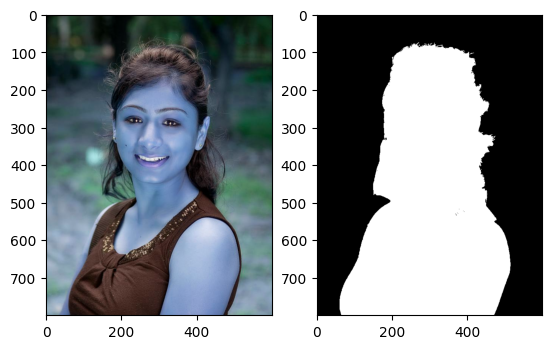

In [15]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(cv2.imread(original_imgs[0])))
ax[1].imshow(np.asarray(cv2.imread('/content/GT_png/'+original_imgs[0].split('/')[-1].replace('.jpg','_mask.png'))))
plt.show()

In [16]:
org_imgs = []
msk_imgs = []
for imgPath in original_imgs:
  maskPath = '/content/GT_png/'+imgPath.split('/')[-1].replace('.jpg','_mask.png')
  if maskPath in mask_imgs:
    org_imgs.append(imgPath)
    msk_imgs.append(maskPath)

In [17]:
print(len(org_imgs))
print(len(msk_imgs))

1630
1630


In [18]:
print(org_imgs[0])
print(msk_imgs[0])

/content/images_data_crop/01176.jpg
/content/GT_png/01176_mask.png


In [19]:
image = cv2.imread(original_imgs[0])
image.shape

(800, 600, 3)

In [20]:
os.mkdir('training')
os.mkdir('training/images')
os.mkdir('validation')
os.mkdir('validation/images')

os.mkdir('training_labels')
os.mkdir('training_labels/images')
os.mkdir('validation_labels')
os.mkdir('validation_labels/images')

## Splitting data into train and validation sets



In [21]:
k = len(org_imgs)//7
random.shuffle(org_imgs)
train_images = org_imgs[k:]
val_images = org_imgs[:k]

train_labels = []
val_labels = []

for img in org_imgs:
  mask = '/content/GT_png/'+img.split('/')[-1].replace('.jpg','_mask.png')
  if img in train_images:
    train_labels.append(mask)
  else:
    val_labels.append(mask)

In [22]:
print(len(train_labels))
print(len(train_images))
print(len(val_labels))
print(len(val_images))

1398
1398
232
232


In [23]:
def moveTo(imgs,folder):
  for img in imgs:
    shutil.copy2(img,folder)

moveTo(train_images,'/content/training/images')
moveTo(train_labels,'/content/training_labels/images')

moveTo(val_images,'/content/validation/images')
moveTo(val_labels,'/content/validation_labels/images')

In [24]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16

In [25]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 5,
    horizontal_flip = True,
    vertical_flip = True,
    height_shift_range = 0.05,
    width_shift_range = 0.05
)
train_label_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 5,
    horizontal_flip = True,
    vertical_flip = True,
    height_shift_range = 0.05,
    width_shift_range = 0.05
)

train_data_flow = train_data_gen.flow_from_directory(
    '/content/training',
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    seed = 42
)

train_label_flow = train_label_gen.flow_from_directory(
    '/content/training_labels',
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    seed = 42
)

val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
val_label_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

val_data_flow = val_data_gen.flow_from_directory(
    '/content/validation',
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    seed = 42
)
val_label_flow = val_label_gen.flow_from_directory(
    '/content/validation_labels',
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE,
    seed = 42
)


Found 1398 images belonging to 1 classes.
Found 1398 images belonging to 1 classes.
Found 232 images belonging to 1 classes.
Found 232 images belonging to 1 classes.


In [26]:
def combine_generators(image_gen, mask_gen):
    while True:
        image_batch = image_gen.next()
        mask_batch = mask_gen.next()
        yield image_batch[0], mask_batch[0]

# Combine the training generators
train_generator = combine_generators(train_data_flow, train_label_flow)

# Combine the validation generators
val_generator = combine_generators(val_data_flow, val_label_flow)

# Building the model

In [27]:
n_channels = 3
n_classes = 1

In [28]:
input = tf.keras.layers.Input(shape = (IMG_HEIGHT,IMG_WIDTH,n_channels)) #256x256x3

#downsize
ds1 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3,padding='same')(input) #256x256x8
ds1 = tf.keras.layers.BatchNormalization()(ds1)
ds1 = tf.keras.layers.Activation(activation = 'relu')(ds1)
ds1 = tf.keras.layers.Conv2D(filters = 8, kernel_size = 3,padding='same')(ds1) #256x256x8
ds1 = tf.keras.layers.BatchNormalization()(ds1)
ds1 = tf.keras.layers.Activation(activation = 'relu')(ds1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(ds1) #128x128x8

ds2 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3,padding='same')(pool1) #128x128x16
ds2 = tf.keras.layers.BatchNormalization()(ds2)
ds2 = tf.keras.layers.Activation(activation = 'relu')(ds2)
ds2 = tf.keras.layers.Conv2D(filters = 16, kernel_size = 3,padding='same')(ds2) #128x128x16
ds2 = tf.keras.layers.BatchNormalization()(ds2)
ds2 = tf.keras.layers.Activation(activation = 'relu')(ds2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(ds2) #64x64x16

ds3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,padding='same')(pool2) #64x64x32
ds3 = tf.keras.layers.BatchNormalization()(ds3)
ds3 = tf.keras.layers.Activation(activation = 'relu')(ds3)
ds3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,padding='same')(ds3) #64x64x32
ds3 = tf.keras.layers.BatchNormalization()(ds3)
ds3 = tf.keras.layers.Activation(activation = 'relu')(ds3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(ds3) #32x32x32

ds4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,padding='same')(pool3) #32x32x64
ds4 = tf.keras.layers.BatchNormalization()(ds4)
ds4 = tf.keras.layers.Activation(activation = 'relu')(ds4)
ds4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,padding='same')(ds4) #32x32x64
ds4 = tf.keras.layers.BatchNormalization()(ds4)
ds4 = tf.keras.layers.Activation(activation = 'relu')(ds4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(ds4) #16x16x64

ds5 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3,padding='same')(pool4) #16x16x128
ds5 = tf.keras.layers.BatchNormalization()(ds5)
ds5 = tf.keras.layers.Activation(activation = 'relu')(ds5)
ds5 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3,padding='same')(ds5) #16x16x128
ds5 = tf.keras.layers.BatchNormalization()(ds5)
ds5 = tf.keras.layers.Activation(activation = 'relu')(ds5)
pool5 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(ds5) #8x8x128

#center

center = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3,padding='same')(pool5) #8x8x256
center = tf.keras.layers.BatchNormalization()(center)
center = tf.keras.layers.Activation(activation = 'relu')(center)
center = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3,padding='same')(center) #8x8x256
center = tf.keras.layers.BatchNormalization()(center)
center = tf.keras.layers.Activation(activation = 'relu')(center)

#upsize
us5 = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,padding='same')(center) #16x16x128
us5 = tf.keras.layers.Concatenate(axis=-1)([us5,ds5])
us5 = tf.keras.layers.Conv2D(filters = 128,kernel_size = 3,padding = 'same')(us5) #16x16x128
us5 = tf.keras.layers.BatchNormalization()(us5)
us5 = tf.keras.layers.Activation(activation='relu')(us5)
us5 = tf.keras.layers.Conv2D(filters = 128,kernel_size = 3,padding = 'same')(us5) #16x16x128
us5 = tf.keras.layers.BatchNormalization()(us5)
us5 = tf.keras.layers.Activation(activation='relu')(us5)

us4 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,padding='same')(us5) #32x32x64
us4 = tf.keras.layers.Concatenate(axis=-1)([us4,ds4])
us4 = tf.keras.layers.Conv2D(filters = 64,kernel_size = 3,padding = 'same')(us4)#32x32x64
us4 = tf.keras.layers.BatchNormalization()(us4)
us4 = tf.keras.layers.Activation(activation='relu')(us4)
us4 = tf.keras.layers.Conv2D(filters = 64,kernel_size = 3,padding = 'same')(us4)#32x32x64
us4 = tf.keras.layers.BatchNormalization()(us4)
us4 = tf.keras.layers.Activation(activation='relu')(us4)

us3 = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,padding='same')(us4) #64x64x32
us3 = tf.keras.layers.Concatenate(axis=-1)([us3,ds3])
us3 = tf.keras.layers.Conv2D(filters = 32,kernel_size = 3,padding = 'same')(us3)#64x64x32
us3 = tf.keras.layers.BatchNormalization()(us3)
us3 = tf.keras.layers.Activation(activation='relu')(us3)
us3 = tf.keras.layers.Conv2D(filters = 32,kernel_size = 3,padding = 'same')(us3)#64x64x32
us3 = tf.keras.layers.BatchNormalization()(us3)
us3 = tf.keras.layers.Activation(activation='relu')(us3)

us2 = tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size = 3, strides = 2,padding='same')(us3) #128x128x16
us2 = tf.keras.layers.Concatenate(axis=-1)([us2,ds2])
us2 = tf.keras.layers.Conv2D(filters = 16,kernel_size = 3,padding = 'same')(us2)#128x128x16
us2 = tf.keras.layers.BatchNormalization()(us2)
us2 = tf.keras.layers.Activation(activation='relu')(us2)
us2 = tf.keras.layers.Conv2D(filters = 16,kernel_size = 3,padding = 'same')(us2)#128x128x16
us2 = tf.keras.layers.BatchNormalization()(us2)
us2 = tf.keras.layers.Activation(activation='relu')(us2)

us1 = tf.keras.layers.Conv2DTranspose(filters = 8, kernel_size = 3, strides = 2,padding='same')(us2) #256x256x8
us1 = tf.keras.layers.Concatenate(axis=-1)([us1,ds1])
us1 = tf.keras.layers.Conv2D(filters = 8,kernel_size = 3,padding = 'same')(us1)#256x256x8
us1 = tf.keras.layers.BatchNormalization()(us1)
us1 = tf.keras.layers.Activation(activation='relu')(us1)
us1 = tf.keras.layers.Conv2D(filters = 8,kernel_size = 3,padding = 'same')(us1)#256x256x8
us1 = tf.keras.layers.BatchNormalization()(us1)
us1 = tf.keras.layers.Activation(activation='relu')(us1)

output = tf.keras.layers.Conv2D(filters = n_classes,kernel_size = 1,activation='sigmoid',padding='same')(us1) # 256x256x1

model = tf.keras.Model(inputs=input,outputs=output)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 8)          32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 8)          0         ['batch_normalization[0][0

In [30]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              loss = 'binary_crossentropy',
              metrics = ['Accuracy',tf.keras.metrics.MeanIoU(num_classes=2)])

In [31]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/logs/best_model.keras',
    monitor = 'val_loss',
    save_best_only = True
)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 6
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 0.001,
    patience = 8
)

In [32]:
train_data_flow.samples

1398

In [33]:
history = model.fit(x = train_generator,
                    epochs= 100,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [model_checkpoint,reducelr,early_stopping],
                    steps_per_epoch = train_data_flow.samples//BATCH_SIZE,
                    validation_steps = val_data_flow.samples//BATCH_SIZE)

Epoch 1/100
87/87 [==============================] - 64s 454ms/step - loss: 0.5549 - Accuracy: 0.7148 - mean_io_u: 0.1921 - val_loss: 4259.6514 - val_Accuracy: 0.6504 - val_mean_io_u: 0.3751 - lr: 0.0100
Epoch 2/100
87/87 [==============================] - 40s 422ms/step - loss: 0.5413 - Accuracy: 0.7165 - mean_io_u: 0.1913 - val_loss: 2.4623 - val_Accuracy: 0.5782 - val_mean_io_u: 0.2002 - lr: 0.0100
Epoch 3/100
87/87 [==============================] - 38s 438ms/step - loss: 0.4764 - Accuracy: 0.7642 - mean_io_u: 0.1907 - val_loss: 1.3552 - val_Accuracy: 0.5557 - val_mean_io_u: 0.1864 - lr: 0.0100
Epoch 4/100
87/87 [==============================] - 38s 441ms/step - loss: 0.4701 - Accuracy: 0.7692 - mean_io_u: 0.1916 - val_loss: 0.5961 - val_Accuracy: 0.7504 - val_mean_io_u: 0.1884 - lr: 0.0100
Epoch 5/100
87/87 [==============================] - 37s 429ms/step - loss: 0.4583 - Accuracy: 0.7751 - mean_io_u: 0.1911 - val_loss: 0.4971 - val_Accuracy: 0.7541 - val_mean_io_u: 0.1882 - lr:

KeyboardInterrupt: 

In [36]:
my_model = tf.keras.models.load_model('/content/logs/best_model.keras')

In [140]:
def predict_mask(model,image_path):
  img = cv2.imread(image_path)
  a,b,c = img.shape
  img_ = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
  img_ = img_.astype('float32')/255.
  img_ = np.expand_dims(img_,axis=0)
  prediction = model.predict(img_)
  print("Original image")
  plt.imshow(img)
  plt.show()
  print('Real Mask')
  real_mask = '/content/validation_labels/images/'+path.split('/')[-1].replace('.jpg','_mask.png')
  plt.imshow(cv2.imread(real_mask))
  plt.show()
  print("Predicted mask")
  plt.imshow(((prediction[0]>0.5)*255).astype('uint8'),cmap='gray')
  plt.show()

In [145]:
path = '/content/validation/images/00713.jpg'
img = cv2.imread(path)
img.shape

(800, 600, 3)

1/1 [==============================] - 0s 20ms/step
Original image


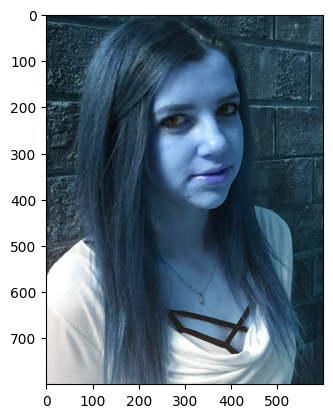

Real Mask


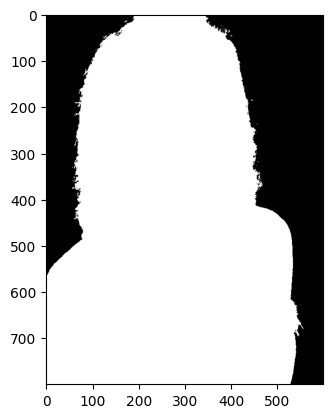

Predicted mask


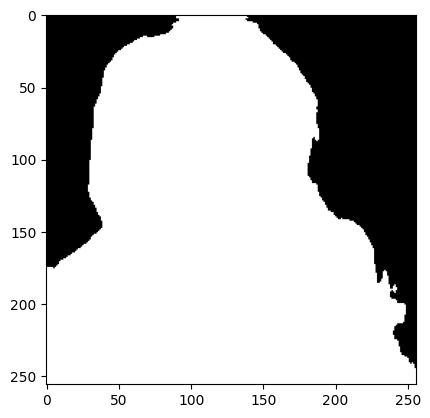

In [146]:
predict_mask(my_model,path)